#  Projet Machine Learning

### Arthur Frachon - Jeanne Collot
https://github.com/jcollot2/DAUPHINE_Machine_Learning

## 1) Sujet

Challenge Data : https://challengedata.ens.fr/challenges/140

### 1.1) Contexte

*Elmy, producteur et fournisseur d'éléctricité*

Dans le cadre de l’activité de valorisation de l’énergie sur les marchés de l’électricité, Elmy aimerait disposer d’un modèle de prévision permettant de juger en amont si les prix de l’électricité sur le marché SPOT (marché d’enchère européen permettant d’acheter de l’électricité la veille pour le lendemain) seront plus ou moins élevés que les prix de l’électricité sur le marché Intraday (marché boursier européen permettant d’acheter de l’électricité le jour même).


L’exercice consiste en la modélisation supervisée de l'écart de prix entre le marché infra-journalier (dit "Intraday") et le marché SPOT. L'écart de prix peut être modélisé par une régression mais aussi par une classification car ce qui importe avant tout est de prédire correctement le sens de cet écart (si tel ou tel prix sera supérieur ou inférieur à l’autre).

### 1.2) Description des données

Index des données : DELIVERY_START qui correspond à la date et l'heure de livraison de l'électricité

**Variables explicatives**
- load_forecast : prévision de consommation totale d'éléctricité en France
- coal_power_available, gas_power_available, nucelear_power_available : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,
- wind_power_forecasts_average, solar_power_forecasts_average : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),
- wind_power_forecasts_std, solar_power_forecasts_std : écart-type de ces mêmes prévisions,
- predicted_spot_price : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.

**Variable cible**
- spot_id_delta : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

### 1.3) Description du benchmark



Un benchmark simple consiste à prédire que les prix sur le marché Intraday sortiront toujours plus haut que les prix sur le marché SPOT. C'est à dire que les valeurs prédites seront toujours positives. On observe en effet que, historiquement, les prix sur le marché intraday sortent un peu plus souvent au dessus des prix au SPOT.


Métrique d'évaluation des performances du modèle
Puisque l'objectif est avant de tout de prédire correctement le sens de l'écart, on s'appuyera sur une métrique de classification pour évaluer la performance d'un modèle. La grandeur de l'écart observé nous importe aussi : plus l'écart observé est important, plus il est important de prédire le correctement son sens. 
La métrique de performance proposée pour ce challenge est donc la Weighted Accuracy. C'est à dire la proprotion des predictions dont les sens (positif ou négatif) est correctement identifié pondérée par la valeur absolue des écarts réellement observés.

## 2) Problématique 

L'objectif est de prédire si le prix du marché Intraday (intra-journalier) sera supérieur ou inférieur au prix SPOT (marché au jour le jour). Nous utilisons la variable spot_id_delta comme cible (positive si Intraday > SPOT, négative sinon).

Stratégie :

- Utiliser une classification binaire avec des modèles supervisés et non supervisés.
- Mesurer la performance des modèles en utilisant la Weighted Accuracy.

## 3) Préparation des données

### 3.1) Importations des bibliothèques

In [1]:
# Imports
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score,make_scorer,silhouette_score,silhouette_samples
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC, SVR
import shap
from IPython.display import HTML
import lime
import lime.lime_tabular
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tabulate import tabulate

warnings.filterwarnings("ignore")

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3.2) Importation des données

##### Importation de nos tables en dataframe pandas

In [2]:
# Charger les fichiers CSV
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)

##### Vérification des tailles des fichiers

In [3]:
print("Structure de nos fichiers :")
print("     X_train shape:", X_train.shape)
print("     y_train shape:", y_train.shape)
print("     X_test shape:", X_test.shape)

Structure de nos fichiers :
     X_train shape: (10605, 9)
     y_train shape: (10605, 1)
     X_test shape: (4942, 9)


### 3.3) Exploration des données 

In [4]:
# Fusionner les cibles avec les features pour exploration
train_data = pd.concat([X_train, y_train], axis=1)

#### Informations sur notre dataset

In [5]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10605 entries, 2022-01-01 02:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  9318 non-null   float64
 1   coal_power_available           10604 non-null  float64
 2   gas_power_available            10604 non-null  float64
 3   nucelear_power_available       10604 non-null  float64
 4   wind_power_forecasts_average   10581 non-null  float64
 5   solar_power_forecasts_average  10581 non-null  float64
 6   wind_power_forecasts_std       10581 non-null  float64
 7   solar_power_forecasts_std      10581 non-null  float64
 8   predicted_spot_price           1846 non-null   float64
 9   spot_id_delta                  10605 non-null  float64
dtypes: float64(10)
memory usage: 911.4+ KB
None


Ce tableau d'informations nous indique que plusieurs colonnes (features) aient des données manquantes.

On constate que la valeur *predicted_spot_price* se compose à 83% de valeur nulle, ce qui va nous poser problème car c'est une valeur qui nous parait indispensable dans notre prediction. Nous allons donc devoir évaluer son rôle dans la prediction. 

#### Informations sur nos features

In [6]:
print(train_data.describe())

       load_forecast  coal_power_available  gas_power_available  \
count    9318.000000          10604.000000         10604.000000   
mean    53725.132968           2819.781592         11463.220671   
std     11274.194929            495.103588           483.799154   
min     30515.000000           1646.000000          9769.000000   
25%     45336.500000           2226.000000         11140.000000   
50%     51846.000000           2806.000000         11487.000000   
75%     62091.750000           3386.000000         11945.000000   
max     85145.000000           3391.000000         11963.000000   

       nucelear_power_available  wind_power_forecasts_average  \
count              10604.000000                  10581.000000   
mean               35393.282252                   4512.989415   
std                 7619.820162                   3349.419356   
min                22285.000000                    592.000000   
25%                29005.000000                   2036.000000   
50%   

#### Corrélation entre les features et la cible

In [7]:
corr_matrix = train_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

On constate que la valeur la plus corrélée avec notre variable cible est notre variable *predicted_spot_price*. Cette observation nous montre que cette variable a donc un rôle important et que nous allons devoir la garder

## 4) Traitement et création de nouvelles features

### 4.1) Ajout de nouvelles features

Nous allons ajouter des colonnes supplémentaires pour essayer d'augmenter nos performances. Nous allons ajouter le prix à la date d'avant du spot et la prediction de chargement précédente à nos données. En effet, ce sont des série temporelle donc il est possible qu'elles apportent des informations supplémentaire.

In [8]:
X_train['spot_before'] = X_train.predicted_spot_price.shift()
X_train['forecast_before'] = X_train.load_forecast.shift()

X_test['spot_before'] = X_test.predicted_spot_price.shift()
X_test['forecast_before'] = X_test.load_forecast.shift()


### 4.2) Normalisation des données

In [9]:
# Normalisation des features numériques
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,index=X_test.index)

# Vérifier les distributions des features
X_train.hist(figsize=(12, 12))
plt.suptitle("Distribution des features normalisées")
plt.show()

### 4.3) Traitement des valeurs manquantes

#### 4.3.1) Remplissage des valeurs manquantes par la moyenne de la colonne

In [10]:
X_train_1 = X_train_scaled.fillna(X_train_scaled.mean())
y_train_1 = y_train.copy()
X_test_1 = X_test_scaled.fillna(X_test_scaled.mean())

##### **Etude des données modifiées :**

<class 'pandas.core.frame.DataFrame'>
Index: 10605 entries, 2022-01-01 02:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  10605 non-null  float64
 1   coal_power_available           10605 non-null  float64
 2   gas_power_available            10605 non-null  float64
 3   nucelear_power_available       10605 non-null  float64
 4   wind_power_forecasts_average   10605 non-null  float64
 5   solar_power_forecasts_average  10605 non-null  float64
 6   wind_power_forecasts_std       10605 non-null  float64
 7   solar_power_forecasts_std      10605 non-null  float64
 8   predicted_spot_price           10605 non-null  float64
 9   spot_before                    10605 non-null  float64
 10  forecast_before                10605 non-null  float64
dtypes: float64(11)
memory usage: 1.2+ MB
None
       load_forecast  coa

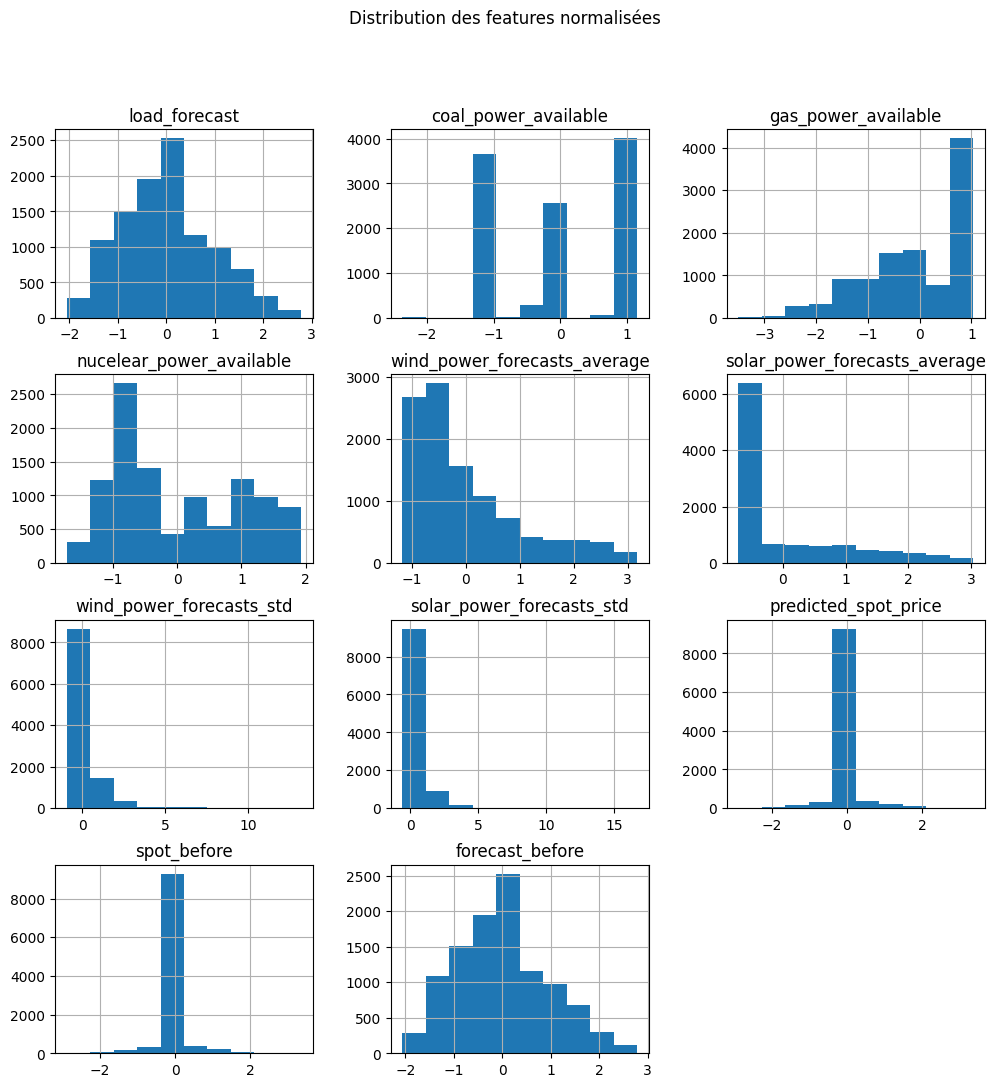

In [11]:
print(X_train_1.info())
print(X_train_1.describe())
X_train_1.hist(figsize=(12, 12))
plt.suptitle("Distribution des features normalisées")
plt.show()

Si on regarde de nouveau nos données après les avoir modifié, nous constatons que nous n'avons plus de valeurs manquantes.

Nous constatons aussi que les distributions restent globalement inchangées sauf celle de notre variable *predicted_spot_price* qui est sévèrement modifiée. Cela s'explique par le fait que la majorité des valeurs étant manquantes, la distribution ne peut que subir une modification importante. If faut donc verifier si la corrélation avec notre variable cible est elle-aussi impactée.

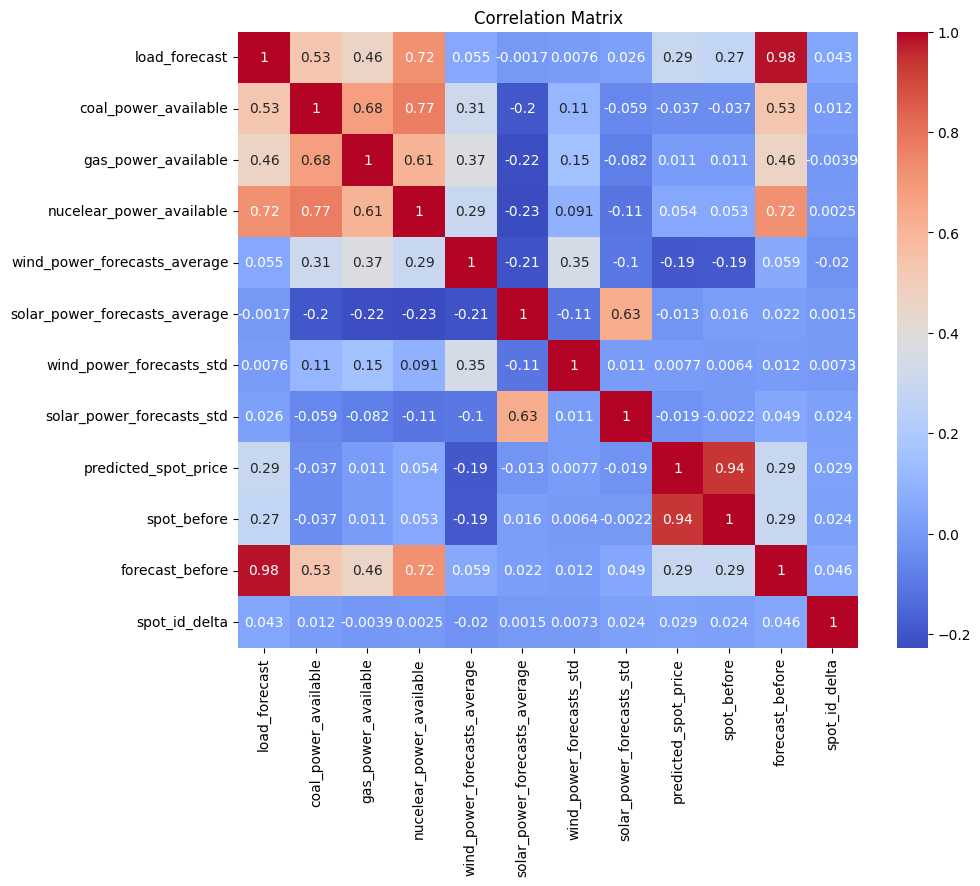

In [12]:
train_data_1= pd.concat([X_train_1, y_train_1], axis=1)
corr_matrix = train_data_1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Nos corrélations n'ont pas été beaucoup impactées non plus à l'exception de notre variable *predicted_spot_price* qui a diminué de façon significative. Ce n'est donc pas une methode optimale.

#### 4.3.2) Calcul des spots prices

Une 2ème méthode consiste à prédire le plus précisemment possible les valeurs spots de l'éléctricité à partir des autres features et des quelques valeurs tests dont nous disposons, nous essaierons plusieurs modèles et garderont celui qui maximise le R².
Nous sommes conscients que cette technique peut ammener à cumuler les erreurs pas la suite mais elle peut également permettre d'améliorer nos résultats.


##### **Traitement des données**

Nous commençons par séparer les données d'entrainement pour lesquels la valeur est fournie et les données test qui sont celles pour lesquelles nous souhaitons remplir la valeur.

In [13]:
data_test = X_train_scaled[X_train_scaled['predicted_spot_price'].isnull()]
data_train = X_train_scaled[~X_train_scaled['predicted_spot_price'].isnull()]
data_train

load_forecast  coal_power_available  \
DELIVERY_START                                                   
2023-01-03 01:00:00+01:00      -0.483443               1.14369   
2023-01-03 02:00:00+01:00      -0.541011               1.14369   
2023-01-03 03:00:00+01:00      -0.716465               1.14369   
2023-01-03 04:00:00+01:00      -0.776428               1.14369   
2023-01-03 05:00:00+01:00      -0.563541               1.14369   
...                                  ...                   ...   
2023-03-29 19:00:00+02:00      -0.258226               1.14369   
2023-03-29 20:00:00+02:00      -0.274725               1.14369   
2023-03-29 21:00:00+02:00      -0.490007               1.14369   
2023-03-29 22:00:00+02:00      -0.510763               1.14369   
2023-03-29 23:00:00+02:00      -0.468452               1.14369   

                           gas_power_available  nucelear_power_available  \
DELIVERY_START                                                             
2023-01-03 01:00:00+01:00             0.995872                  0.918269   
2023-01-03 02:00:00+01:00             0.995872                  0.918269   
2023-01-03 03:00:00+01:00             0.995872                  0.918269   
2023-01-03 04:00:00+01:00             0.995872                  0.918269   
2023-01-03 05:00:00+01:00             0.995872                  0.918269   
...                                        ...                       ...   
2023-03-29 19:00:00+02:00             1.010342                  0.384111   
2023-03-29 20:00:00+02:00             1.010342                  0.384111   
2023-03-29 21:00:00+02:00             1.010342                  0.384111   
2023-03-29 22:00:00+02:00             1.010342                  0.384111   
2023-03-29 23:00:00+02:00             1.010342                  0.384111   

                           wind_power_forecasts_average  \
DELIVERY_START                                            
2023-01-03 01:00:00+01:00                     -0.215268   
2023-01-03 02:00:00+01:00                     -0.143312   
2023-01-03 03:00:00+01:00                     -0.093450   
2023-01-03 04:00:00+01:00                     -0.045679   
2023-01-03 05:00:00+01:00                     -0.005371   
...                                                 ...   
2023-03-29 19:00:00+02:00                      0.907367   
2023-03-29 20:00:00+02:00                      1.142046   
2023-03-29 21:00:00+02:00                      1.374038   
2023-03-29 22:00:00+02:00                      1.529594   
2023-03-29 23:00:00+02:00                      1.680075   

                           solar_power_forecasts_average  \
DELIVERY_START                                             
2023-01-03 01:00:00+01:00                      -0.709050   
2023-01-03 02:00:00+01:00                      -0.709050   
2023-01-03 03:00:00+01:00                      -0.709050   
2023-01-03 04:00:00+01:00                      -0.709050   
2023-01-03 05:00:00+01:00                      -0.709050   
...                                                  ...   
2023-03-29 19:00:00+02:00                      -0.468548   
2023-03-29 20:00:00+02:00                      -0.668781   
2023-03-29 21:00:00+02:00                      -0.709050   
2023-03-29 22:00:00+02:00                      -0.709050   
2023-03-29 23:00:00+02:00                      -0.709050   

                           wind_power_forecasts_std  \
DELIVERY_START                                        
2023-01-03 01:00:00+01:00                 -0.460626   
2023-01-03 02:00:00+01:00                 -0.289021   
2023-01-03 03:00:00+01:00                 -0.432307   
2023-01-03 04:00:00+01:00                 -0.494938   
2023-01-03 05:00:00+01:00                 -0.577213   
...                                             ...   
2023-03-29 19:00:00+02:00                  0.923286   
2023-03-29 20:00:00+02:00                  0.230014   
2023-03-29 21:00:00+02:00                  0.011239   
2023-03-29 22:00:00+02:00

Nous allons maintenant traiter nos données en supprimant les lignes contenant des valeurs manquantes.

In [14]:
data_train = data_train.dropna()
data_test = data_test.fillna(data_test.mean())

Nous allons maintenant isoler la variable cible des variables explicative.

In [15]:
## Target
X_fill = data_train[[col for col in data_train.columns if col !='predicted_spot_price']]
y_fill = data_train[['predicted_spot_price']]
X_fill_reste = data_test[[col for col in data_train.columns if col !='predicted_spot_price']]
y_fill_reste = data_test[['predicted_spot_price']]
## Format
X_fill= pd.get_dummies(X_fill)

A partir de ces set X et y de nos données d'entraiment, nous allons les reseparer en un set pour entrainer le modèle et un set pour le tester.

In [16]:
X_fill_train, X_fill_test, y_fill_train, y_fill_test = sk.model_selection.train_test_split(X_fill, y_fill, test_size=0.2, random_state=42)

##### **Sélection du modèle**

Nous allons donc tester plusieurs modèles sur nos données d'entrainement pour trouver celui qui maximisera l'accuracy de notre prediction. Nous nous concentrerons sur des modèles de regression car la valeur cible est le prix prédit de l'electricité.

In [17]:
models = {
    'XGBoost' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'K-Neighbors Regression': KNeighborsRegressor()}

res = list()
for mod in models.values() :
    print(f"Model: {mod.__class__.__name__}")
    # Initialiser le modèle
    model = mod
    # Entraîner le modèle de base
    model.fit(X_fill_train, y_fill_train)
    # Évaluation du modèle
    y_pred = model.predict(X_fill_test)
    mse = mean_squared_error(y_fill_test, y_pred)
    r2 = r2_score(y_fill_test, y_pred)    
    # Validation croisée
    cv_scores = sk.model_selection.cross_val_score(model, X_fill_train, y_fill_train, cv=10, scoring='neg_mean_squared_error')
    res.append([mod.__class__.__name__,mse,r2,cv_scores])

Model: XGBRegressor
Model: LinearRegression
Model: Ridge
Model: Lasso
Model: ElasticNet
Model: SVR
Model: DecisionTreeRegressor
Model: RandomForestRegressor
Model: GradientBoostingRegressor
Model: KNeighborsRegressor


In [18]:
res = pd.DataFrame(res,columns=["model","mse","r2","cv_score"]).sort_values(by="r2",ascending=False)
res["cv_mean"] = res['cv_score'].apply(lambda x : np.mean(x))
res.head(5)

model       mse        r2  \
8  GradientBoostingRegressor  0.047991  0.956772   
5                        SVR  0.053913  0.951437   
0               XGBRegressor  0.057913  0.947834   
7      RandomForestRegressor  0.059164  0.946708   
1           LinearRegression  0.061309  0.944775   

                                            cv_score   cv_mean  
8  [-0.05069065449984909, -0.06552453935454469, -... -0.058141  
5  [-0.04889548606449529, -0.0679201981256527, -0... -0.055215  
0  [-0.0513818970528894, -0.06686931365564376, -0... -0.059634  
7  [-0.0667504003563717, -0.08058494119613317, -0... -0.066780  
1  [-0.05958326120388844, -0.07098240006148063, -... -0.062714

Nous constatons que le modèle XGBoost prédit des valeurs avec l'accuracy la plus importante donc nous allons choisir ce type modèle pour nos predictions. Mais avant de passer à la prédiction, nous allons optimiser les hyperparamètres de ce modèle.

##### **Optimisation des hyperparamètres**

In [19]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2,0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.2,0.4,0.6, 0.8, 1.0],
    'colsample_bytree': [0.2,0.4,0.6, 0.8, 1.0]
}

grid_search = sk.model_selection.GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_fill_train, y_fill_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


In [20]:
y_pred_best = best_model.predict(X_fill_test)
best_mse = mean_squared_error(y_fill_test, y_pred_best)
best_r2 = r2_score(y_fill_test, y_pred_best)

print(f"Best Mean Squared Error: {best_mse}")
print(f"Best R^2 Score: {best_r2}")

best_cv_scores = sk.model_selection.cross_val_score(best_model, X_fill_train, y_fill_train, cv=5, scoring='neg_mean_squared_error')
print(f"Best Cross-Validation Scores (neg MSE): {best_cv_scores}")
print(f"Mean Best Cross-Validation Score (neg MSE): {best_cv_scores.mean()}")

Best Mean Squared Error: 0.04555875381442978
Best R^2 Score: 0.9589626487300639
Best Cross-Validation Scores (neg MSE): [-0.04934717 -0.05464029 -0.04827713 -0.06196696 -0.04997376]
Mean Best Cross-Validation Score (neg MSE): -0.052841061150731394


Avec notre optimisation d'hyperparamètre, nous avons identifié un modèle qui est plus précis. Nous le retiendrons donc pour la prédiction du *predicted_spot_price*.

In [21]:
print('Hyperparamètres optimaux :')
best_params

Hyperparamètres optimaux :


{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200,
 'subsample': 0.6}

##### **Remplissage des valeurs manquantes**

Nous allons donc remplir les valeurs manquantes de X_train avec ce modèle.

In [22]:
X_fill_reste = pd.get_dummies(X_fill_reste)
y_fill_reste = best_model.predict(X_fill_reste)

Maintenant que nous avons predit ces valeurs, nous allons reconsituer le fichier X_train avec les valeurs complétée pour l'utiliser dans la suite de notre travail.

In [23]:
X_fill_reste['predicted_spot_price'] = y_fill_reste
X_train_2 = pd.concat([data_train,X_fill_reste]).sort_index()
#X_train_2.to_csv("X_train_2.csv")
X_train_2

load_forecast  coal_power_available  \
DELIVERY_START                                                   
2022-01-01 02:00:00+01:00      -0.380192               1.14369   
2022-01-01 03:00:00+01:00      -0.639914               1.14369   
2022-01-01 04:00:00+01:00      -0.759929               1.14369   
2022-01-01 05:00:00+01:00      -0.793548               1.14369   
2022-01-01 06:00:00+01:00      -0.748753               1.14369   
...                                  ...                   ...   
2023-03-29 19:00:00+02:00      -0.258226               1.14369   
2023-03-29 20:00:00+02:00      -0.274725               1.14369   
2023-03-29 21:00:00+02:00      -0.490007               1.14369   
2023-03-29 22:00:00+02:00      -0.510763               1.14369   
2023-03-29 23:00:00+02:00      -0.468452               1.14369   

                           gas_power_available  nucelear_power_available  \
DELIVERY_START                                                             
2022-01-01 02:00:00+01:00             0.049154                  1.145057   
2022-01-01 03:00:00+01:00             0.049154                  1.145057   
2022-01-01 04:00:00+01:00             0.049154                  1.145057   
2022-01-01 05:00:00+01:00             0.049154                  1.145057   
2022-01-01 06:00:00+01:00             0.049154                  1.145057   
...                                        ...                       ...   
2023-03-29 19:00:00+02:00             1.010342                  0.384111   
2023-03-29 20:00:00+02:00             1.010342                  0.384111   
2023-03-29 21:00:00+02:00             1.010342                  0.384111   
2023-03-29 22:00:00+02:00             1.010342                  0.384111   
2023-03-29 23:00:00+02:00             1.010342                  0.384111   

                           wind_power_forecasts_average  \
DELIVERY_START                                            
2022-01-01 02:00:00+01:00                     -0.441288   
2022-01-01 03:00:00+01:00                     -0.409042   
2022-01-01 04:00:00+01:00                     -0.365749   
2022-01-01 05:00:00+01:00                     -0.318276   
2022-01-01 06:00:00+01:00                     -0.249007   
...                                                 ...   
2023-03-29 19:00:00+02:00                      0.907367   
2023-03-29 20:00:00+02:00                      1.142046   
2023-03-29 21:00:00+02:00                      1.374038   
2023-03-29 22:00:00+02:00                      1.529594   
2023-03-29 23:00:00+02:00                      1.680075   

                           solar_power_forecasts_average  \
DELIVERY_START                                             
2022-01-01 02:00:00+01:00                      -0.709050   
2022-01-01 03:00:00+01:00                      -0.709050   
2022-01-01 04:00:00+01:00                      -0.709050   
2022-01-01 05:00:00+01:00                      -0.709050   
2022-01-01 06:00:00+01:00                      -0.709050   
...                                                  ...   
2023-03-29 19:00:00+02:00                      -0.468548   
2023-03-29 20:00:00+02:00                      -0.668781   
2023-03-29 21:00:00+02:00                      -0.709050   
2023-03-29 22:00:00+02:00                      -0.709050   
2023-03-29 23:00:00+02:00                      -0.709050   

                           wind_power_forecasts_std  \
DELIVERY_START                                        
2022-01-01 02:00:00+01:00                 -0.349241   
2022-01-01 03:00:00+01:00                 -0.481457   
2022-01-01 04:00:00+01:00                 -0.613775   
2022-01-01 05:00:00+01:00                 -0.675551   
2022-01-01 06:00:00+01:00                 -0.714482   
...                                             ...   
2023-03-29 19:00:00+02:00                  0.923286   
2023-03-29 20:00:00+02:00                  0.230014   
2023-03-29 21:00:00+02:00                  0.011239   
2023-03-29 22:00:00+02:00

Nous ajustons ensuite les valeurs de y_train en supprimant les lignes que nous avons supprimé chez X_train pour garder le même nombre d'éléments.

In [24]:
y_train_2 = y_train.loc[X_train_2.index]

Nous appliquons maintenant le même raisonnement à X_test. Mais à la place de supprimer les lignes aux valeurs manquantes, nous allons les remplacer par leur moyenne.

In [25]:
data_fill = X_test_scaled[X_test_scaled['predicted_spot_price'].isnull()]
data_keep = X_test_scaled[~X_test_scaled['predicted_spot_price'].isnull()]

In [26]:
X_test_test = data_fill[[col for col in data_fill.columns if col !='predicted_spot_price']]
X_test_test = pd.get_dummies(X_test_test)
y_test_test = best_model.predict(X_test_test)

In [27]:
X_test_test['predicted_spot_price'] = y_test_test
X_test_2 = pd.concat([data_keep,X_test_test]).sort_index()
#X_test_2.to_csv("X_train_filled.csv")

##### **Etudes des nouvelles données**

In [28]:
print(X_train_2.info())
print(X_train_2.describe())
X_train_2.hist(figsize=(12, 12))
plt.suptitle("Distribution des features normalisées")
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 10577 entries, 2022-01-01 02:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  10577 non-null  float64
 1   coal_power_available           10577 non-null  float64
 2   gas_power_available            10577 non-null  float64
 3   nucelear_power_available       10577 non-null  float64
 4   wind_power_forecasts_average   10577 non-null  float64
 5   solar_power_forecasts_average  10577 non-null  float64
 6   wind_power_forecasts_std       10577 non-null  float64
 7   solar_power_forecasts_std      10577 non-null  float64
 8   predicted_spot_price           10577 non-null  float64
 9   spot_before                    10577 non-null  float64
 10  forecast_before                10577 non-null  float64
dtypes: float64(11)
memory usage: 991.6+ KB
None
       load_forecast  c

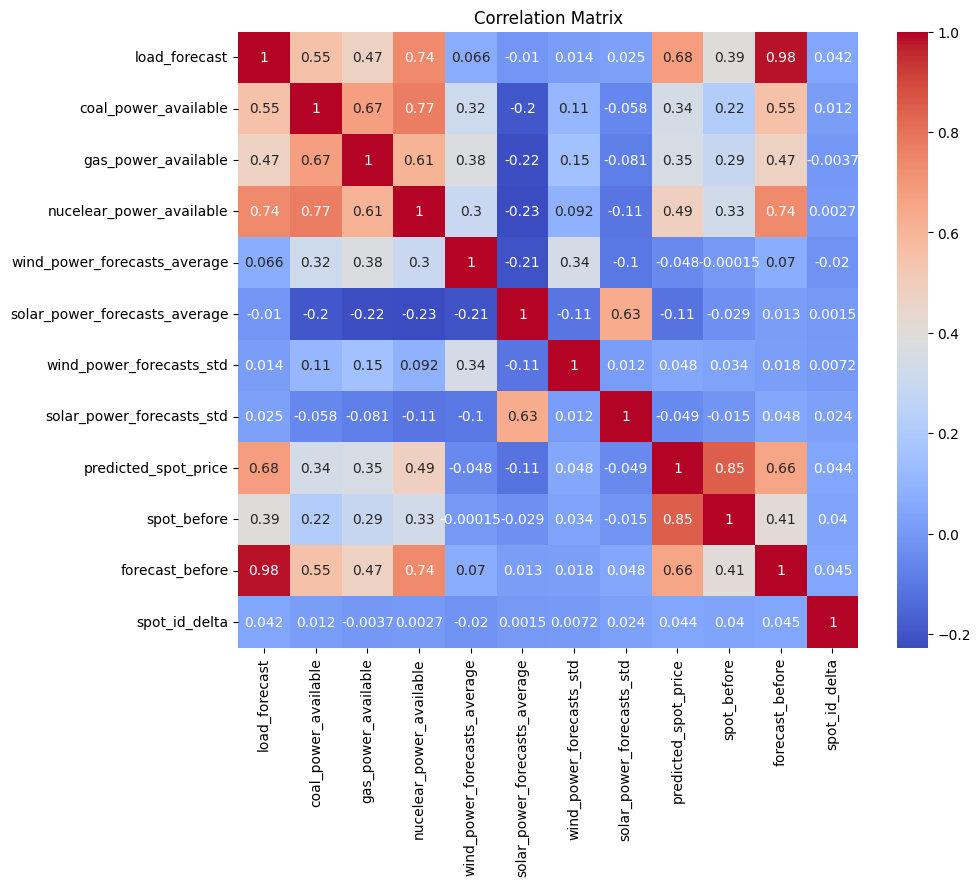

In [29]:
train_data_2= pd.concat([X_train_2, y_train_2], axis=1)
corr_matrix = train_data_2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Nos corrélations n'ont pas été beaucoup impactées non plus à l'exception de notre variable *predicted_spot_price* qui a diminué de façon significative. Ce n'est donc toujours pas une methode optimale.

#### 4.3.3) Supprimer les lignes pour lesquels les predicted spot sont manquantes 

Nous commençons par supprimer les valeurs manquantes des *predicted_spot_price* puis on prend la moyenne des valeurs manquantes pour les autres colonnes.

In [30]:
X_train_3 = X_train_scaled.dropna(subset=['predicted_spot_price'],axis=0)
X_train_3 = X_train_3.fillna(X_train_3.mean())
X_test_3 = X_test_scaled.fillna(X_test_scaled.mean())
y_train_3 = y_train.loc[X_train_3.index]

##### **Etude des données**

In [31]:
print(X_train_3.info())
print(X_train_3.describe())
X_train_3.hist(figsize=(12, 12))
plt.suptitle("Distribution des features normalisées")
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 1846 entries, 2023-01-03 01:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  1846 non-null   float64
 1   coal_power_available           1846 non-null   float64
 2   gas_power_available            1846 non-null   float64
 3   nucelear_power_available       1846 non-null   float64
 4   wind_power_forecasts_average   1846 non-null   float64
 5   solar_power_forecasts_average  1846 non-null   float64
 6   wind_power_forecasts_std       1846 non-null   float64
 7   solar_power_forecasts_std      1846 non-null   float64
 8   predicted_spot_price           1846 non-null   float64
 9   spot_before                    1846 non-null   float64
 10  forecast_before                1846 non-null   float64
dtypes: float64(11)
memory usage: 173.1+ KB
None
       load_forecast  co

On applique la même logique au dataset de X_test et on garde les lignes de y_train dont on a conservé la valeur

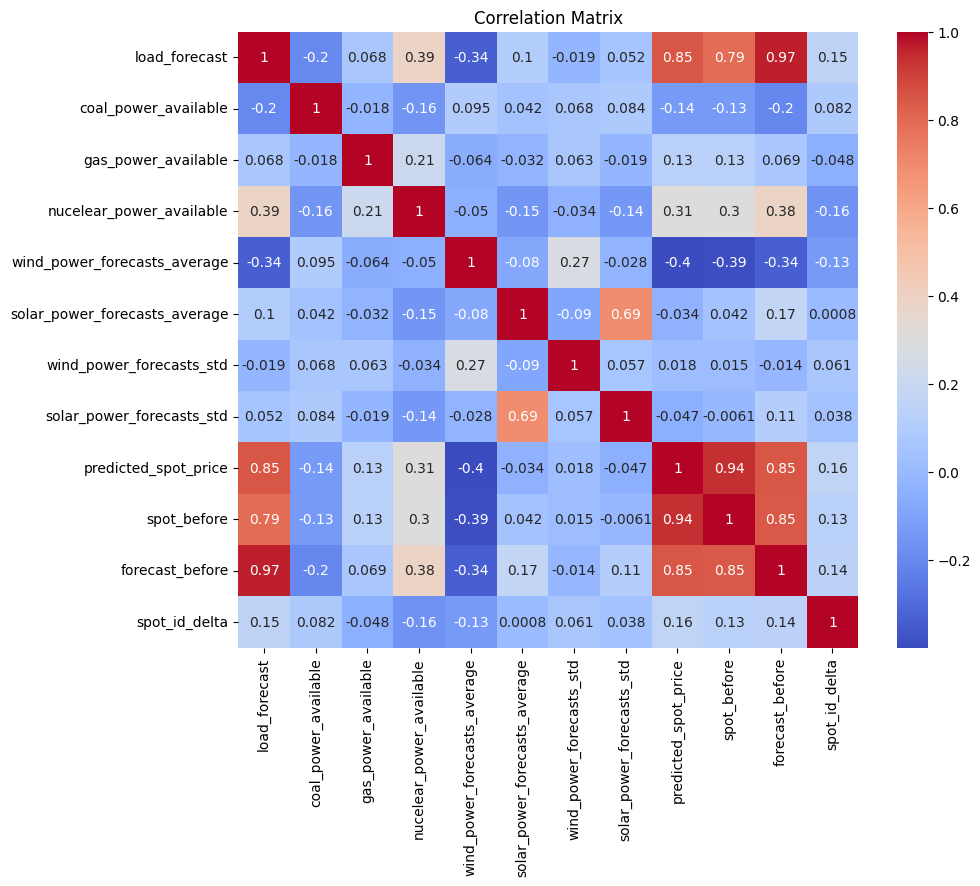

In [32]:
train_data_3= pd.concat([X_train_3, y_train_3], axis=1)
corr_matrix = train_data_3.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Nous constatons que c'est la seule approche qui nous permet de maintenir une forte corréalation entre le *predicted_spot_price* et la varible cible. Nous nous attendons donc à la voir performer plus dans le reste de notre travail.

## 5) Benchmark

Le benchmark proposé par le challenge est un jeu de données ou nos prédictions (delta : Intraday - spot) sont tous positifs, il s'agit d'un problème de classification, une régression logistique simple peut donc servir de comparaison pour nos modèles.
Comparons déjà  nos deux approches sur un modèle benchmark

##### **Mesure de performance demandée par le challenge**

In [33]:
# Weighted Accuracy
def weighted_accuracy(y_true, y_pred):
    correct_predictions = (np.sign(y_true) == np.sign(y_pred)).astype(int)
    return np.sum(correct_predictions * np.abs(y_true)) / np.sum(np.abs(y_true))

Nous adaptons également cette metrique pour qu'elle soit utilisable dans nos GridSearch au moment de l'optimisation de nos hyperparamètre.

In [34]:
custom_score = make_scorer(weighted_accuracy, greater_is_better=True)

Nous rangeons également nos methodes dans une liste pour pouvoir y aplliquer plus facilement les modèles.

In [35]:
methods = [(X_train_1,y_train_1),(X_train_2,y_train_2),(X_train_3,y_train_3)]

##### **Création et Entrainement du modèle**

In [36]:
comparaison=[]
result_baseline=[]
for i,method in enumerate(methods):
    X_train_method,y_train_method = method

    # Split des données
    X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)

    # Transformation de la cible en binaire (positif/négatif)
    y_train_method_train = (y_train_method_train['spot_id_delta'] > 0).astype(int)

    # Modèle baseline : Régression Logistique
    baseline_model = LogisticRegression(max_iter=1000, random_state=42)
    baseline_model.fit(X_train_method_train, y_train_method_train)

    # Prédictions et évaluation
    y_pred_baseline = baseline_model.predict(X_train_method_test)

    # Mesure de Performance
    wacc_baseline = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_baseline)
    result_baseline.append((f"Method_{i+1}",wacc_baseline,baseline_model))
   
result_baseline = pd.DataFrame(result_baseline,columns=["Methode","W_Accuracy","Modele"])
result_baseline

Methode  W_Accuracy                                             Modele
0  Method_1    0.297570  LogisticRegression(max_iter=1000, random_state...
1  Method_2    0.254737  LogisticRegression(max_iter=1000, random_state...
2  Method_3    0.536617  LogisticRegression(max_iter=1000, random_state...

Nous obtenons des resultats pour chacune de nos methodes de données. Nous constatons que pour ce modèle, la méthode 3 est celle qui fournie les meilleurs résultats. Cette observation s'explique par le fait que ces données sont celle pour lesquelles les variables explicatives sont plus corrélées avec la cible. Ces résultats nous permettent de conclure que les methodes de données 1 et 2 ne sont pas concluantes. Nous n'allons donc plus les utiliser. De plus, dans la suite de notre travail, les écart se creusent.

##### **Optimisation des hyperparamètre**

Nous garderons donc la methode 2 pour cette optimisation car c'est celle pour laquelle le modèle est le plus performant.

In [37]:
X_train_method,y_train_method = methods[2]
X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
y_train_method_train = (y_train_method_train['spot_id_delta'] > 0).astype(int)


In [38]:
param_grid = {
    'max_iter': [100, 200, 500, 1000, 2000],  # Nombres d'itérations
    'C': [0.001, 0.01, 0.1, 1, 10, 100],      # Paramètre de régularisation
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Algorithmes d'optimisation
}

# Configuration de la recherche en grille avec validation croisée
grid_search = sk.model_selection.GridSearchCV(LogisticRegression(random_state=42), param_grid=param_grid, scoring=custom_score, cv=3, n_jobs=None, verbose=0)
grid_search.fit(X_train_method_train, y_train_method_train)

# Meilleur modèle et paramètres
baseline_model = grid_search.best_estimator_
print("Meilleur modèle:", baseline_model)

Meilleur modèle: LogisticRegression(C=0.001, random_state=42, solver='newton-cg')


In [39]:
y_pred_optimized = baseline_model.predict(X_train_method_test)
wacc_baseline = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_optimized)
comparaison.append(["Methode_baseline","LogisticRegression",wacc_baseline])
wacc_baseline

0.6437786569846814

Le modèle ainsi selectionné a de meilleurs performance que ceux précédents, nous allons donc le garder en tant que benchemark.
Nous allons donc l'utiliser pour prédire les *spot_id_delta* de nos données test. 

##### **Prédiction des valeurs**

In [40]:
X_test_method = X_test_3
y_test_baseline = baseline_model.predict(X_test_method)
y_test_baseline = pd.DataFrame(y_test_baseline,index=X_test_method.index,columns=['spot_id_delta'])
y_test_baseline.to_csv('y_test_baseline.csv')

Nous avons testé ce résultat et nous obtenons bien le même résultats que le benchmark. 

## 6) Modèle non supervisé

Avec une méthode d'apprentissage non supervisée, on ne pourraient pas prédire directement le spot_id_delta. Mais on peut envisager de l'utiliser pour explorer ou prétraiter les données avant d'utiliser un modèle supervisé.

Nous utiliserons donc d'abord une Décomposition en Composante Principales pour observer nos données, puis utiliserons un Kmeans pour regrouper nos données afin d'améliorer nos résultats de nos modèles supervisés. 

### 6.1) ACP

Nous commençons par appliquer une ACP sur nos données pour réduire le nombre de dimensions. Nous affichons la reprensentation de notre nuage de points sur 3 dimensions et la courbe de la variance expliquée en fonction du nombre de dimensions choisis pour notre décomposition.

In [41]:
methods = [("Stardard",X_train_3,y_train_3,X_test_3)]

Methode 1
Variance expliquée : [0.41590411 0.60124254 0.76700025 0.85987104 0.91258535 0.9437329
 0.97019647 0.98679548 0.99430401 0.9988088  1.        ]


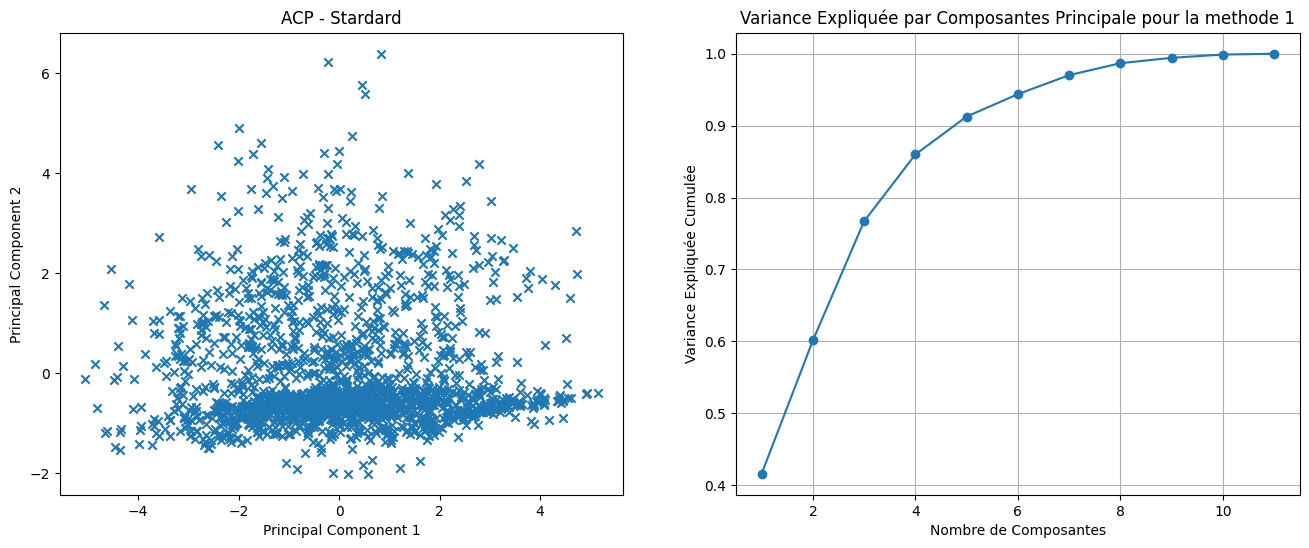

In [42]:
result_kmeans = []
for i,method in enumerate(methods):
    nom,X_train_method,y_train_method,X_test_method=method
    # PCA pour la réduction de dimensions
    pca = PCA() #Pour affichage graphique
    x_train_pca = pca.fit_transform(X_train_method)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f"Methode {i+1}\nVariance expliquée : {cumulative_variance}")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    # Visualisation des clusters
    axes[0].scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1],marker="x")
    axes[0].set_title(f"ACP - {nom}")
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')

    # Visualisation de l'évolution de la variance
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    axes[1].set_xlabel('Nombre de Composantes')
    axes[1].set_ylabel('Variance Expliquée Cumulée')
    axes[1].set_title(f'Variance Expliquée par Composantes Principale pour la methode {i+1}')
    axes[1].grid(True)
    plt.show()
   

Observations :
* La courbe montre une augmentation plus importante de la variance expliquée avec les premières composantes donc elles capturent une partie plus importantes des informations.
* Pour expliquer plus de 95% de la variance, nous devons garder au minimum 7.

### 6.2) Kmeans

#### 6.2.1) Ajout de Features

Nous allons utiliser un kmeans pour regrouper nos données en cluster et leur ajouter des données qui pourraient être utiles dans notre analyse. Nous pouvons ajouter des valeurs sur les centres de gravité de nos données, ou sur des moyennes des valeur de nos cluster comme celle du *predicted_spot_price*. Nous allons donc génerer ces deux features et tester ces nouvelles méthodes de données dans la suite de notre travail. 

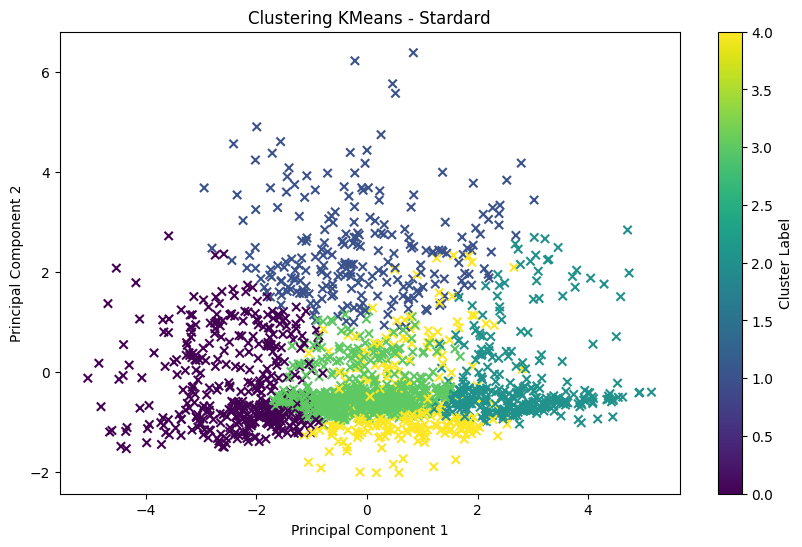

In [43]:
methods_features=[]
for i,method in enumerate(methods):
    nom,X_train_method,y_train_method,X_test_method=method
    # PCA pour la réduction de dimensions
    pca = PCA()
    x_train_pca = pca.fit_transform(X_train_method)
    x_test_pca = pca.transform(X_test_method)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(x_train_pca)
    clusters = kmeans.predict(x_train_pca)
    clusters_test = kmeans.predict(x_test_pca)

    # Visualisation des clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1], c=clusters, marker= 'x', cmap='viridis')
    plt.title(f"Clustering KMeans - {nom}")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

    # ajout des centroids et cluster aux données existantes
    x_train_pca = pd.DataFrame(x_train_pca,index=X_train_method.index)
    x_test_pca = pd.DataFrame(x_test_pca,index=X_test_method.index)
    clusters = pd.DataFrame(clusters,index=X_train_method.index,columns=['cluster'])
    clusters_test = pd.DataFrame(clusters_test,index=X_test_method.index,columns=['cluster'])
    centroids = kmeans.cluster_centers_
    for i,c in enumerate(centroids) :
        for j in range(len(c)):
            clusters.loc[clusters.cluster==i,f'cluster_{j}'] = c[j]
            clusters_test.loc[clusters_test.cluster==i,f'cluster_{j}'] = c[j]
    data_cluster = pd.concat([X_train_method,clusters],axis=1)
    data_cluster_test = pd.concat([X_test_method,clusters_test],axis=1)
    methods_features.append(('Cluster',data_cluster,y_train_method,data_cluster_test))

    # ajout de la moyenne
    data_cluster_1 = X_train_method.copy()
    data_cluster_1['mean_spot_cluster'] = data_cluster.groupby('cluster')['predicted_spot_price'].transform('mean')
    data_cluster_test_1 = X_test_method.copy()
    data_cluster_test_1['mean_spot_cluster'] = data_cluster_test.groupby('cluster')['predicted_spot_price'].transform('mean')
    methods_features.append(('Mean',data_cluster_1,y_train_method,data_cluster_test_1))


In [44]:
methods = methods + methods_features

##### **Etudes de nouvelles données**

In [45]:
print(methods_features[0][1].info())
methods_features[0][1].describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1846 entries, 2023-01-03 01:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  1846 non-null   float64
 1   coal_power_available           1846 non-null   float64
 2   gas_power_available            1846 non-null   float64
 3   nucelear_power_available       1846 non-null   float64
 4   wind_power_forecasts_average   1846 non-null   float64
 5   solar_power_forecasts_average  1846 non-null   float64
 6   wind_power_forecasts_std       1846 non-null   float64
 7   solar_power_forecasts_std      1846 non-null   float64
 8   predicted_spot_price           1846 non-null   float64
 9   spot_before                    1846 non-null   float64
 10  forecast_before                1846 non-null   float64
 11  cluster                        1846 non-null   int32  
 12  cluster_

load_forecast  coal_power_available  gas_power_available  \
count    1846.000000           1846.000000          1846.000000   
mean        0.570460              0.822327             0.944821   
std         0.771460              0.648425             0.198205   
min        -1.369318             -2.370892            -0.213364   
25%        -0.025647              0.881106             0.995872   
50%         0.551809              1.143690             0.995872   
75%         1.135762              1.143690             0.995872   
max         2.374565              1.153790             1.010342   

       nucelear_power_available  wind_power_forecasts_average  \
count               1846.000000                   1846.000000   
mean                   0.981117                      0.464925   
std                    0.419506                      1.136745   
min                    0.209558                     -1.116960   
25%                    0.554070                     -0.441885   
50%                    1.081011                      0.219604   
75%                    1.348746                      1.056579   
max                    1.623044                      3.181003   

       solar_power_forecasts_average  wind_power_forecasts_std  \
count                    1846.000000               1846.000000   
mean                       -0.139253                  0.096187   
std                         0.869182                  1.007353   
min                        -0.709050                 -0.917365   
25%                        -0.709050                 -0.533521   
50%                        -0.709050                 -0.197744   
75%                         0.317148                  0.407754   
max                         2.979759                  7.180071   

       solar_power_forecasts_std  predicted_spot_price  spot_before  ...  \
count                1846.000000           1846.000000  1846.000000  ...   
mean                   -0.046639              0.000000     0.001541  ...   
std                     0.953557              1.000271     0.999200  ...   
min                    -0.580229             -2.884871    -2.884679  ...   
25%                    -0.580229             -0.614830    -0.610323  ...   
50%                    -0.580229             -0.006370    -0.002412  ...   
75%                     0.104288              0.604744     0.604318  ...   
max                     7.943389              3.359548     3.358634  ...   

         cluster_1    cluster_2    cluster_3    cluster_4    cluster_5  \
count  1846.000000  1846.000000  1846.000000  1846.000000  1846.000000   
mean      0.000160    -0.000745     0.000006     0.000118     0.000004   
std       0.933225     0.805652     0.221303     0.072382     0.064103   
min      -0.538663    -0.823398    -0.250735    -0.174933    -0.071033   
25%      -0.426454    -0.823398    -0.187233     0.013605    -0.063621   
50%      -0.244074    -0.156775    -0.176811     0.017395    -0.000780   
75%      -0.199911     0.294137     0.262467     0.043241     0.083468   
max       2.418221     1.668577     0.262467     0.045612     0.083468   

         cluster_6    cluster_7    cluster_8    cluster_9   cluster_10  
count  1846.000000  1846.000000  1846.000000  1846.000000  1846.000000  
mean      0.000030     0.000071    -0.000019     0.000012    -0.000002  
std       0.029033     0.044383     0.017359     0.022232     0.005768  
min      -0.062045    -0.081743    -0.013204    -0.034300    -0.012921  
25%      -0.006188    -0.045495    -0.013204    -0.016924    -0.001994  
50%       0.004025     0.001695    -0.011042     0.002504    -0.000389  
75%       0.028919     0.034813     0.003393     0.024878     0.005572  
max       0.028919     0.050044     0.039221     0.025303     0.005572  

[8 rows x 23 columns]

Nous avons donc ajouté des colonnes à nos données. Mais ce qui nous interesse le plus est leur corrélation avec la variable cible. Nous allons donc les tracer pour nos 3 methodes de données.

In [46]:
for i,method in enumerate(methods_features):  
    train_data_kmeans= pd.concat([method[1], method[2]], axis=1)
    corr_matrix = train_data_kmeans.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f"Matrice de Correlation pour la Methode {i+1}")
    plt.show()

Pour les deux premières methodes, les nouvelles données sont très peu corrélée avec la variable cible. Mais pour notre méthode 3, les données sont un peu plus corrélées et apportent des informations supplémentaire. Nous les garderons donc pour nos prévisions.

#### 6.2.2) Prediction après clustering

Nous allons utiliser un Kmeans pour faire une prédictions de notre variable cible.

In [47]:
result_kmeans = []
for i,method in enumerate(methods):
    nom,X_train_method,y_train_method,X_test_method=method
    # PCA pour la réduction de dimensions
    pca = PCA()
    x_train_pca = pca.fit_transform(X_train_method)
    x_train_pca = pd.DataFrame(x_train_pca,index=X_train_method.index)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=20, random_state=42)
    kmeans.fit(x_train_pca)
    x_train_pca['cluster'] = kmeans.predict(x_train_pca)

    # Compute y_pred as means of cluster for training
    x_train_pca = pd.concat([x_train_pca,y_train_method],axis=1)
    groups = x_train_pca.groupby(by='cluster')
    map_y = {}
    for nb,group in groups:
        map_y[nb] = group.spot_id_delta.mean()
    x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

    # compute metrics
    w_acc = weighted_accuracy(y_train_method["spot_id_delta"],x_train_pca['y_pred'])
    result_kmeans.append([f"Methode_{nom}",20,w_acc,kmeans,map_y,pca])
result_kmeans=pd.DataFrame(result_kmeans,columns=['Methode','nb_composante','W_Accuracy','Model','Map','PCA'])

In [48]:
result_kmeans

Methode  nb_composante  W_Accuracy  \
0  Methode_Stardard             20    0.726275   
1   Methode_Cluster             20    0.687634   
2      Methode_Mean             20    0.705436   

                                    Model  \
0  KMeans(n_clusters=20, random_state=42)   
1  KMeans(n_clusters=20, random_state=42)   
2  KMeans(n_clusters=20, random_state=42)   

                                                 Map    PCA  
0  {0: 3.9913294888037805, 1: -0.7806099581360444...  PCA()  
1  {0: 5.090235310922655, 1: 3.894772512485785, 2...  PCA()  
2  {0: 6.7500641879977845, 1: -1.2124675125855495...  PCA()

##### **Optimisation**

La methode 3 est celle qui à la weighted accuracy la plus importante. Nous allons donc essayer d'optimiser notre modèle avec ce set de données. Commençons par chercher le nombre de cluster idéal.

In [49]:
# Fonction pour calculer le score de silhouette pour un nombre de clusters donné
def compute_silhouette_score(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    return score

score_sil = []
kmax = 500
for k in range(2, kmax,2):
    result = compute_silhouette_score(k, X_train_3)
    score_sil.append(result)


# Afficher les scores de silhouette
#k_values, silhouette_scores_home = zip(*[(result[0], result[1]) for result in score_sil])
plt.figure(figsize=(10, 6))
plt.plot([k for k in range(2, kmax,2)],score_sil, marker='o')
plt.title('Silhouette Score for different numbers of clusters (Home)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Extraire les meilleurs résultats
score = max(score_sil)
k_ideal = score_sil.index(score) +2
print(f"Meilleur nb de cluster :",k_ideal," pour un score de ",score)


Meilleur nb de cluster : 2  pour un score de  0.24964557736219695


Le score de silhouette nous donne 2 comme nombre de cluster idéal. Cependant, pour le bien de la prediction, nous allons en prendre plus et vérifier si les performances sont meilleures.

In [50]:
# PCA pour la réduction de dimensions
pca = PCA()
x_train_pca = pca.fit_transform(X_train_3)
x_train_pca = pd.DataFrame(x_train_pca,index=X_train_3.index)

# KMeans Clustering
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(x_train_pca)
x_train_pca['cluster'] = kmeans.predict(x_train_pca)

# Compute y_pred as means of cluster for training
x_train_pca = pd.concat([x_train_pca,y_train_3],axis=1)
groups = x_train_pca.groupby(by='cluster')
map_y = {}
for nb,group in groups:
    map_y[nb] = group.spot_id_delta.mean()
x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

# compute metrics
w_acc = weighted_accuracy(y_train_3["spot_id_delta"],x_train_pca['y_pred'])
comparaison.append([f"Methode_{nom}","Kmeans",w_acc])
w_acc

0.7396118154884794

Nous obtenons bien une meilleure performance en prédiction, donc nous retenons ce modèle.

##### **Prediction du *spot_id_delta***

In [51]:
model = kmeans
X_test_Kmeans = X_test_3.copy()
X_test_Kmeans = pd.DataFrame(pca.transform(X_test_Kmeans),index=X_test_Kmeans.index)
X_test_Kmeans['cluster'] = kmeans.predict(X_test_Kmeans)
X_test_Kmeans['spot_id_delta'] = X_test_Kmeans['cluster'].apply(lambda x : map_y[x])
y_test_Kmeans = X_test_Kmeans[['spot_id_delta']]
y_test_Kmeans

spot_id_delta
DELIVERY_START                          
2023-04-02 00:00:00+02:00       5.807492
2023-04-02 01:00:00+02:00       5.807492
2023-04-02 02:00:00+02:00       5.807492
2023-04-02 03:00:00+02:00       5.807492
2023-04-02 04:00:00+02:00       5.807492
...                                  ...
2023-10-24 19:00:00+02:00      -6.604100
2023-10-24 20:00:00+02:00      -6.604100
2023-10-24 21:00:00+02:00      11.335626
2023-10-24 22:00:00+02:00      11.335626
2023-10-24 23:00:00+02:00       8.829438

[4942 rows x 1 columns]

In [52]:
y_test_Kmeans.to_csv('y_test_Kmeans.csv')

Après soummission, nous obtenons une weighted accuracy de 0,5209416312886466.

## 7) Modèle supervisé

### 7.1) Classification

Dans cette partie, nous allons tester plusieurs modèle de classification différents et comparer notre accuracy pour nos 3 methodes de données afin de trouver le modèle le plus performants.

##### **Selection des modèles**

Il faut discretiser y_train. On peut utiliser une conversion en entier relatif (avec le signe). Nous avons choisi de prendre la valeur entière la plus proche que nous avons plafonnée entre -15 et 20.

In [53]:
result_supervised = []
for i,method in enumerate(methods):
    # Split
    nom,X_train_method,y_train_method,X_test_method=method
    X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = sk.model_selection.train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
    #y_train_method_train = y_train_method_train.astype(int)['spot_id_delta']
    y_train_method_train=np.clip(y_train_method_train.astype(int), -15, 20)

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_method_train, y_train_method_train)
    y_pred_rf = rf_model.predict(X_train_method_test)
    weighted_acc_rf = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_rf)
    result_supervised.append((f"Methode_{nom}","RF",weighted_acc_rf,rf_model))
    
    # SVM
    svm_model = SVC(random_state=42)
    svm_model.fit(X_train_method_train, y_train_method_train)
    y_pred_svm = svm_model.predict(X_train_method_test)
    weighted_acc_svm = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_svm)
    result_supervised.append((f"Methode_{nom}","SVM",weighted_acc_svm,svm_model))

    # Regression logistique
    rl_model = LogisticRegression(multi_class='multinomial')
    rl_model.fit(X_train_method_train, y_train_method_train)
    y_pred_rl = rl_model.predict(X_train_method_test)
    weighted_acc_rl = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_rl)
    result_supervised.append((f"Methode_{nom}","Logistic",weighted_acc_rl,rl_model))

    # KNN
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_method_train, y_train_method_train)
    y_pred_knn = knn_model.predict(X_train_method_test)
    weighted_acc_knn = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_knn)
    result_supervised.append((f"Methode_{nom}","KNN",weighted_acc_knn,knn_model))

result_supervised=pd.DataFrame(result_supervised,columns=[f"Methode","Type","W_Accuracy","Modele"])
result_supervised.sort_values('W_Accuracy',inplace=True)

In [54]:
result_supervised

Methode      Type  W_Accuracy  \
5    Methode_Cluster       SVM    0.496633   
1   Methode_Stardard       SVM    0.522721   
9       Methode_Mean       SVM    0.524486   
10      Methode_Mean  Logistic    0.559814   
7    Methode_Cluster       KNN    0.571941   
2   Methode_Stardard  Logistic    0.572484   
6    Methode_Cluster  Logistic    0.574568   
11      Methode_Mean       KNN    0.579165   
3   Methode_Stardard       KNN    0.585006   
0   Methode_Stardard        RF    0.788814   
8       Methode_Mean        RF    0.803752   
4    Methode_Cluster        RF    0.828606   

                                               Modele  
5                                SVC(random_state=42)  
1                                SVC(random_state=42)  
9                                SVC(random_state=42)  
10      LogisticRegression(multi_class='multinomial')  
7                              KNeighborsClassifier()  
2       LogisticRegression(multi_class='multinomial')  
6       LogisticRegression(multi_class='multinomial')  
11                             KNeighborsClassifier()  
3                              KNeighborsClassifier()  
0   (DecisionTreeClassifier(max_features='sqrt', r...  
8   (DecisionTreeClassifier(max_features='sqrt', r...  
4   (DecisionTreeClassifier(max_features='sqrt', r...

In [55]:
result_supervised

Methode      Type  W_Accuracy  \
5    Methode_Cluster       SVM    0.496633   
1   Methode_Stardard       SVM    0.522721   
9       Methode_Mean       SVM    0.524486   
10      Methode_Mean  Logistic    0.559814   
7    Methode_Cluster       KNN    0.571941   
2   Methode_Stardard  Logistic    0.572484   
6    Methode_Cluster  Logistic    0.574568   
11      Methode_Mean       KNN    0.579165   
3   Methode_Stardard       KNN    0.585006   
0   Methode_Stardard        RF    0.788814   
8       Methode_Mean        RF    0.803752   
4    Methode_Cluster        RF    0.828606   

                                               Modele  
5                                SVC(random_state=42)  
1                                SVC(random_state=42)  
9                                SVC(random_state=42)  
10      LogisticRegression(multi_class='multinomial')  
7                              KNeighborsClassifier()  
2       LogisticRegression(multi_class='multinomial')  
6       LogisticRegression(multi_class='multinomial')  
11                             KNeighborsClassifier()  
3                              KNeighborsClassifier()  
0   (DecisionTreeClassifier(max_features='sqrt', r...  
8   (DecisionTreeClassifier(max_features='sqrt', r...  
4   (DecisionTreeClassifier(max_features='sqrt', r...

Avec nos resultats, le modèle de Random Forest avec la methode de données 3 parait la plus performante. Nous allons donc retenir ces choix et faire une optimisation des hyperparamètres afin de trouver le modèle le plus performant.

##### **Optimisation des hyperparamètre**

In [56]:
nom,X_train_method,y_train_method,X_test_method = methods[1]
nom = 'Cluster'

In [57]:
X_train_train, X_train_test, y_train_train, y_train_test = sk.model_selection.train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
y_train_train = np.clip(y_train_method_train.astype(int), -15, 20)
 #y_train_train.astype(int)['spot_id_delta']

In [58]:
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans la forêt
    'max_features': ['sqrt', 'log2'],  # Nombre de caractéristiques à considérer à chaque division
    'max_depth': [None, 10, 15],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5],  # Nombre minimum de données nécessaires pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum de données requises à chaque feuille
}

rf = RandomForestClassifier(random_state=42)
grid_search = sk.model_selection.GridSearchCV(estimator=rf, param_grid=param_grid,scoring=custom_score, cv=3, n_jobs=None, verbose=0)
grid_search.fit(X_train_train, y_train_train)
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

Meilleurs paramètres trouvés :  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [59]:
model_rf = grid_search.best_estimator_
pred = model_rf.predict(X_train_test)
weighted_acc = weighted_accuracy(y_train_test['spot_id_delta'], pred)
comparaison.append([f"Methode_{nom}","RandomForestClassifier",weighted_acc])
weighted_acc

0.8144037628426313

In [60]:
#model_rf.get_params()

##### **Prediction sur nos données X_test**

In [61]:
y_test_final = model_rf.predict(X_test_method)
y_test_final = pd.DataFrame(y_test_final,index=X_test_method.index,columns=["spot_id_delta"])
y_test_final.to_csv("y_rf.csv")

Sur la plateforme, nous obtenons 0,4781.

### 7.2) Regression

##### **Selection des modèles**

In [62]:
result_supervised = []
for i,method in enumerate(methods):
    # Split
    nom,X_train_method,y_train_method,X_test_method=method
    X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = sk.model_selection.train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
    
    # LinearRegression
    lin_model = LinearRegression()
    lin_model.fit(X_train_method_train, y_train_method_train)
    y_pred_lin = lin_model.predict(X_train_method_test)
    weighted_acc_lin = weighted_accuracy(y_train_method_test, y_pred_lin)['spot_id_delta']
    result_supervised.append((f"Methode_{nom}","Linear",weighted_acc_lin,lin_model))
    
    # Ridge
    ridge_model = Ridge(alpha=0.1,random_state=42)
    ridge_model.fit(X_train_method_train, y_train_method_train)
    y_pred_ridge = ridge_model.predict(X_train_method_test)
    weighted_acc_ridge = weighted_accuracy(y_train_method_test, y_pred_ridge)['spot_id_delta']
    result_supervised.append((f"Methode_{nom}","ridge",weighted_acc_ridge,ridge_model))

    # SVR
    svr_model = SVR()
    svr_model.fit(X_train_method_train, y_train_method_train)
    y_pred_svr = svr_model.predict(X_train_method_test)
    weighted_acc_svr = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_svr)
    result_supervised.append((f"Methode_{nom}","SVR",weighted_acc_svr,svr_model))

    # RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100)
    rf_model.fit(X_train_method_train, y_train_method_train)
    y_pred_rf = rf_model.predict(X_train_method_test)
    weighted_acc_rf = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_rf)
    result_supervised.append((f"Methode_{nom}","RF",weighted_acc_rf,rf_model))

result_supervised=pd.DataFrame(result_supervised,columns=[f"Methode","Type","W_Accuracy","Modele"])
result_supervised.sort_values('W_Accuracy',inplace=True)

In [63]:
result_supervised

Methode    Type  W_Accuracy  \
8       Methode_Mean  Linear    0.666780   
9       Methode_Mean   ridge    0.666780   
6    Methode_Cluster     SVR    0.674956   
0   Methode_Stardard  Linear    0.676190   
1   Methode_Stardard   ridge    0.676190   
4    Methode_Cluster  Linear    0.676982   
5    Methode_Cluster   ridge    0.676982   
2   Methode_Stardard     SVR    0.716073   
10      Methode_Mean     SVR    0.737564   
3   Methode_Stardard      RF    0.859493   
11      Methode_Mean      RF    0.867430   
7    Methode_Cluster      RF    0.871351   

                                               Modele  
8                                  LinearRegression()  
9                   Ridge(alpha=0.1, random_state=42)  
6                                               SVR()  
0                                  LinearRegression()  
1                   Ridge(alpha=0.1, random_state=42)  
4                                  LinearRegression()  
5                   Ridge(alpha=0.1, random_state=42)  
2                                               SVR()  
10                                              SVR()  
3   (DecisionTreeRegressor(max_features=1.0, rando...  
11  (DecisionTreeRegressor(max_features=1.0, rando...  
7   (DecisionTreeRegressor(max_features=1.0, rando...

Le random Forest semble être le modèle le plus performant. Nous allons optimiser ses paramètres afin d'obtenir le meilleur modèle possible.

##### **Optimisation des hyperparamètre**

In [64]:
nom="Standard"
X_train_3_train, X_train_3_test, y_train_3_train, y_train_3_test = sk.model_selection.train_test_split(X_train_3, y_train_3, test_size=0.2, random_state=42)

In [65]:
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans la forêt
    'max_features': ['sqrt', 'log2'],  # Nombre de caractéristiques à considérer à chaque division
    'max_depth': [None, 10, 15],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5],  # Nombre minimum de données nécessaires pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum de données requises à chaque feuille
}

rf = RandomForestRegressor(random_state=42)
grid_search = sk.model_selection.GridSearchCV(estimator=rf, param_grid=param_grid,scoring=custom_score, cv=3, n_jobs=None, verbose=0)
grid_search.fit(X_train_3_train, y_train_3_train.astype(int))
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

Meilleurs paramètres trouvés :  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [66]:
model_rf = grid_search.best_estimator_
pred = model_rf.predict(X_train_3_test)
weighted_acc = weighted_accuracy(y_train_3_test['spot_id_delta'], pred)
comparaison.append([f"Methode_{nom}","RandomForestRegressor",weighted_acc])
weighted_acc

0.8735314403370656

##### **Prediction sur nos données X_test**

In [67]:
y_test_final = model_rf.predict(X_test_3)
y_test_final = pd.DataFrame(y_test_final,index=X_test_3.index,columns=["spot_id_delta"])
y_test_final.to_csv("y_rf_reg.csv")

### 7.3) Modèle d'ensemble

Nous allons également utiliser un modèle "VotingClassifier" qui nous permet de combiner plusieurs modèles d'apprentissage pour obtenir une prédiction. 

**Ajustement des données**

In [91]:
Nnom = "Standard"
X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = train_test_split(X_train_3, y_train_3, test_size=0.2, random_state=42)
y_train_method_train = np.clip(y_train_method_train.astype(int), 0, 5)


**Creation du modèle**

In [92]:
# Définir les modèles individuels
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = KNeighborsClassifier()

# Créer le VotingClassifier
voting_hard = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('knn', model3)], voting='hard')
voting_soft = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('knn', model3)], voting='soft')

**Optimisation des hyperparamètre**

In [93]:
# Définir l'espace des hyperparamètres à explorer
param_grid = {
    'lr__C': [0.1, 1, 10],             
    'rf__n_estimators': [50, 100, 200], 
    'rf__max_depth': [None, 10, 20],    
    'knn__n_neighbors': [3, 5, 7],      
    'knn__weights': ['uniform', 'distance'] 
}

# Recherche d'hyperparamètres avec validation croisée
grid_search_hard = GridSearchCV(estimator=voting_hard, param_grid=param_grid, scoring=custom_score, cv=5)
grid_search_hard.fit(X_train_method_train, y_train_method_train)

grid_search_soft = GridSearchCV(estimator=voting_hard, param_grid=param_grid,scoring=custom_score, cv=5)
grid_search_soft.fit(X_train_method_train, y_train_method_train)

# Afficher les meilleurs hyperparamètres et la meilleure précision
print("Meilleurs hyperparamètres hard:", grid_search_hard.best_params_)
print("Meilleurs hyperparamètres hard:", grid_search_soft.best_params_)

Meilleurs hyperparamètres hard: {'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'lr__C': 0.1, 'rf__max_depth': None, 'rf__n_estimators': 50}
Meilleurs hyperparamètres hard: {'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'lr__C': 0.1, 'rf__max_depth': None, 'rf__n_estimators': 50}


In [94]:
model_soft = grid_search_soft.best_estimator_
model_hard = grid_search_hard.best_estimator_

In [96]:
# Prediction avec le VotingClassifier
y_pred_hard = model_soft.predict(X_train_method_test)
y_pred_soft = model_hard.predict(X_train_method_test)

# Calculer Metrique
accuracy_soft = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_soft)
accuracy_hard = weighted_accuracy(y_train_method_test['spot_id_delta'], y_pred_hard)
comparaison.append([f"Methode_{nom}","VotingClassifierSoft",accuracy_soft])
comparaison.append([f"Methode_{nom}","VotingClassifierHard",accuracy_hard])

print("Weighted Accuracy du VotingClassifier Soft :", accuracy_soft)
print("Weighted Accuracy du VotingClassifier Hard:", accuracy_hard)

Weighted Accuracy du VotingClassifier Soft : 0.47067677320848966
Weighted Accuracy du VotingClassifier Hard: 0.45987152260190295


##### **Predictions**

In [73]:
y_pred_hard = model_soft.predict(X_test_3)
y_pred_soft = model_hard.predict(X_test_3)

In [74]:
y_pred_hard = pd.DataFrame(y_pred_hard,index=X_test_3.index,columns=['spot_id_delta'])
y_pred_soft = pd.DataFrame(y_pred_soft,index=X_test_3.index,columns=['spot_id_delta'])
y_pred_hard.to_csv("y_test_hard.csv")
y_pred_soft.to_csv("y_test_soft.csv")

## 8) Intérprétation des modèles 

**Interpretation de l'importances des variables explicatives**

In [75]:
# Get feature importances from the model
feature_importances = pd.DataFrame({
    'Feature': X_train_3.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importances

Feature  Importance
3        nucelear_power_available    0.156959
0                   load_forecast    0.132714
4    wind_power_forecasts_average    0.123171
8            predicted_spot_price    0.114417
10                forecast_before    0.114254
6        wind_power_forecasts_std    0.091864
9                     spot_before    0.080476
2             gas_power_available    0.055822
1            coal_power_available    0.045243
7       solar_power_forecasts_std    0.042835
5   solar_power_forecasts_average    0.042246

Nous constatons que dans ce modèle de regression Random Forest, la variable la plus importante est *load_forecast* et *nuclear_power_available*. 

**Interpretation détaillée**

In [76]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_train_3)

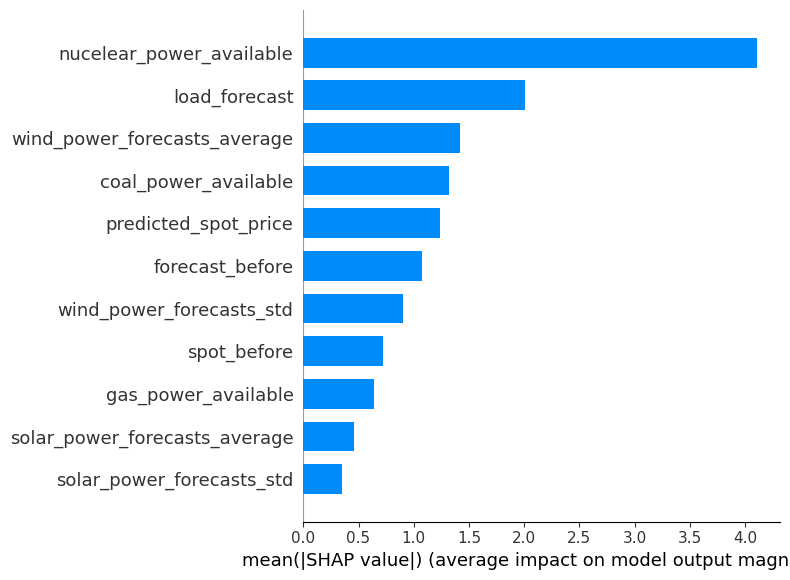

In [77]:
class_index = 23
shap.summary_plot(shap_values[:, :], X_train_3, plot_type="bar")


In [78]:
style = """
<style>
    .lime, .lime * {
        background-color: #BBD;
        color: black;
    }
</style>
"""
HTML(style)


In [79]:
# Initialiser l'expliqueur LIME pour les données tabulaires
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_3.values,
    feature_names=X_train_3.columns,
    class_names=['spot_id_delta'],
    mode='regression'
)

# Choisissez une instance spécifique que vous souhaitez expliquer
i = 23  # index de l'instance dans X_train_imputed
exp = explainer.explain_instance(
    data_row=X_train_3.iloc[i].values, 
    predict_fn=model_rf.predict
)

# Afficher l'explication
exp.show_in_notebook(show_table=True, show_all=False)


## 9) Modèle de Deep Learning

### 9.1) Réseau de Neurone standard

##### **Definition de notre metrique**

Nous commençons par définir notre métrique en tensorflow pour pouvoir ensuite l'utiliser dans nos réseaux de neurones.

In [80]:
# Définition de la métrique 
class WeightedAccuracy(Metric):
    def __init__(self, name="weighted_accuracy", **kwargs):
        super(WeightedAccuracy, self).__init__(name=name, **kwargs)
        self.total_weighted_accuracy = self.add_weight(name="total_weighted_accuracy", initializer="zeros")
        self.total_weight = self.add_weight(name="total_weight", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        correct_predictions = tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32)
        weights = tf.abs(y_true)
        weighted_correct_predictions = correct_predictions * weights
        self.total_weighted_accuracy.assign_add(tf.reduce_sum(weighted_correct_predictions))
        self.total_weight.assign_add(tf.reduce_sum(weights))

    def result(self):
        return self.total_weighted_accuracy / self.total_weight

    def reset_states(self):
        self.total_weighted_accuracy.assign(0)
        self.total_weight.assign(0)

##### **Construction du modèle et entrainement du modèle**

Nous construisons ensuite notre modèle. Nous somme parti sur un réseau en 4 couches simples qui essaye de maximiser notre métrique "WeightedAccuracy"

Nous entrainons un modèle par méthode de données en essayant de maximiser notre métrique. Nous utilisons également un checkpoint qui va nous permettre de récupérer le meilleure modèle même si ne n'est pas le dernier produit.

In [81]:
# Entraînement du modèle
result_reseau = []
for i,method in enumerate(methods):
    print("Methode ",i+1)
    nom,X_train_method,y_train_method,X_test_method = method
    X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
    
    model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_method_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[WeightedAccuracy()])
    checkpoint = ModelCheckpoint(
        'model_deeplearning.h5',          
        monitor='weighted_accuracy', 
        verbose=0,              
        save_best_only=True,   
        mode='max',               
        save_weights_only=False   
    )
    history = model.fit(X_train_method_train, y_train_method_train, epochs=40, batch_size=32, validation_split=0.2,verbose=0, callbacks=[checkpoint])
    # Recuperation du meilleur modèle
    model_reseau = load_model('model_deeplearning.h5', custom_objects={'WeightedAccuracy': WeightedAccuracy})
    y_res= model_reseau.predict(X_train_method_test,verbose=0)
    w_acc= weighted_accuracy(y_train_method_test,y_res)['spot_id_delta']
    result_reseau.append([f"Methode_{nom}","Reseau",w_acc,model_reseau])
    comparaison.append([f"Methode_{nom}","Reseau",w_acc])

result_reseau=pd.DataFrame(result_reseau,columns=[f"Methode_{i+1}","Type","W_Accuracy","Modele"])

Methode  1



Methode  2
Methode  3


In [82]:
result_reseau

Methode_3    Type  W_Accuracy  \
0  Methode_Stardard  Reseau    0.643779   
1   Methode_Cluster  Reseau    0.643779   
2      Methode_Mean  Reseau    0.643779   

                                              Modele  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

Nous constatons que les résultats ne sont pas très encourageant. Le modèle reste quand même plus performant sur nos données traité par la méthode 3.

##### **Prédiction sur nos données X_test**

In [83]:
model_reseau = result_reseau.Modele.iloc[0]

In [84]:
y_reseau = model_reseau.predict(X_test_3)
y_reseau = pd.DataFrame(y_reseau,index=X_test_3.index,columns=['spot_id_delta'])
y_reseau.to_csv('y_test_reseau.csv')

155/155 [==============================] - 0s 1ms/step


### 9.2) Modèle LSTM

##### **Création du modèle**

In [85]:
# Define the LSTM model
model_lstm = Sequential([
    LSTM(50, input_shape=(1, 11), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error',metrics=[WeightedAccuracy()])

##### **Entrainement du modèle**

Nous utilisons un "EarlyStopping" qui nous permet d'arrêter l'entrainement quand la métrique n'augmente plus pour éviter l'overfitting.

In [86]:
# Formatage des données
split_point = int(0.8 * len(X_train_3))
X_train_res = X_train_3[:split_point]
y_train_res = y_train_3[:split_point]
X_test_res = X_train_3[split_point:]
y_test_res = y_train_3[split_point:]

# Reshaping pour LSTM si nécessaire
X_train_res = X_train_res.values.reshape((X_train_res.shape[0], 1, X_train_res.shape[1]))
X_test_res = X_test_res.values.reshape((X_test_res.shape[0], 1, X_test_res.shape[1]))

# Entrainement du modèle
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = model_lstm.fit(X_train_res, y_train_res, epochs=100, validation_split=0.2, verbose=1, batch_size=32,callbacks=[early_stopping])

Epoch 1/100
37/37 [==============================] - 4s 24ms/step - loss: 223.3442 - weighted_accuracy: 0.0000e+00 - val_loss: 455.1532 - val_weighted_accuracy: 0.0000e+00
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 220.1202 - weighted_accuracy: 0.2796 - val_loss: 446.2574 - val_weighted_accuracy: 0.6157
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 212.0755 - weighted_accuracy: 0.4523 - val_loss: 433.7518 - val_weighted_accuracy: 0.6786
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 207.0197 - weighted_accuracy: 0.4573 - val_loss: 431.1095 - val_weighted_accuracy: 0.6114
Epoch 5/100
37/37 [==============================] - 0s 6ms/step - loss: 204.5739 - weighted_accuracy: 0.4276 - val_loss: 431.6533 - val_weighted_accuracy: 0.5809
Epoch 6/100
37/37 [==============================] - 0s 5ms/step - loss: 202.8515 - weighted_accuracy: 0.3971 - val_loss: 432.9735 - val_weighted_accuracy: 0.5504
Epoch 7/100
3

In [87]:
y_res_LSTM= model_lstm.predict(X_test_res,verbose=0)
w_acc_LSTM = weighted_accuracy(y_test_res,y_res_LSTM)
comparaison.append([f"Methode_Standard","LSTM",w_acc_LSTM])

print("WeightedAccuracy pour le LSTM : ",w_acc_LSTM['spot_id_delta']) 

WeightedAccuracy pour le LSTM :  0.4206619989082071


Le resultat pour notre métrique est assez encourageant. Nous allons donc l'utiliser pour prédire nos valeurs test.

##### **Prediction sur X_test**

In [88]:
X_test_3_reshaped = X_test_3.values.reshape((X_test_3.shape[0], 1, X_test_3.shape[1]))
y_test_LSTM = model_lstm.predict(X_test_3_reshaped)
y_test_LSTM = pd.DataFrame(y_test_LSTM,index=X_test_3.index,columns=['spot_id_delta'])
y_test_LSTM = y_test_LSTM.to_csv('y_test_LSTM.csv')

155/155 [==============================] - 0s 2ms/step


## 10) Comparaison des résultats

In [89]:
comparaison_finale = pd.DataFrame(comparaison,columns=['Methode',"Modele","Weighted_Accuracy"])
print(tabulate(comparaison_finale, headers = "keys", tablefmt = "fancy_grid"))

╒════╤══════════════════╤════════════════════════╤═════════════════════╕
│    │ Methode          │ Modele                 │   Weighted_Accuracy │
╞════╪══════════════════╪════════════════════════╪═════════════════════╡
│  0 │ Methode_baseline │ LogisticRegression     │            0.643779 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  1 │ Methode_Mean     │ Kmeans                 │            0.739612 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  2 │ Methode_Cluster  │ RandomForestClassifier │            0.814404 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  3 │ Methode_Standard │ RandomForestRegressor  │            0.873531 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  4 │ Methode_Standard │ VotingClassifierSoft   │            0.453453 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  5 │ Methode_Standard │ VotingClassifierHard   │ 

Ainsi, parmi les 9 modèles construits celui qui prédit le mieux les signes de nos deltas de prix de l'éléctricité tout en prenant en compte la taille du delta est le modèle de Random Forest en regression appliqué à un dataset auquel on a supprimé toutes les valeurs nulles.